In [1]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

from pymc3 import Normal,Metropolis, sample,find_MAP

plt.rcParams.update({'font.size': 18})

In [2]:
def f(x):
    return 2*x + 1

x=np.random.uniform(0,1,10000)


x0 = []
y0 = []

x1 = []
y1 = []

Y1=np.zeros(len(x))

X1=np.zeros((len(x),2))


for i in range(len(x)):

    
    if np.random.random() < x[i]:
        x0.append(x[i])
        y0.append( f(x[i]) + np.random.normal(0,0.25)  )

        
    else:
        x1.append(x[i])
        y1.append( f(x[i]) + np.random.normal(0,0.25) ) 

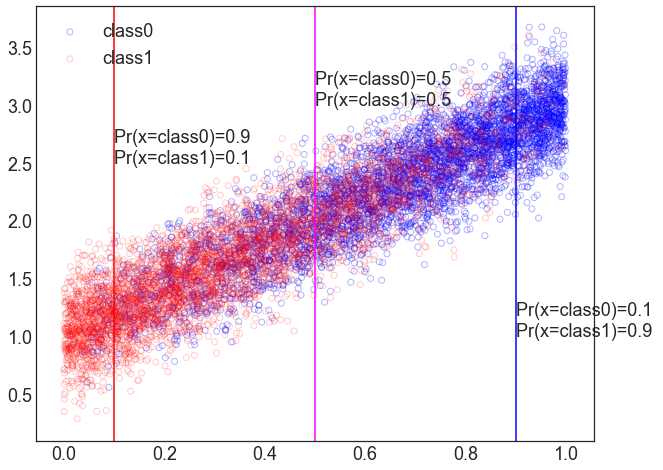

In [3]:
Y1=np.zeros(len(x0))
Y2=np.ones(len(x1))
Y=np.concatenate((Y1, Y2), axis=0)

x=np.concatenate((x0, x1), axis=0)
y=np.concatenate((y0, y1), axis=0)

X=np.stack((x, y), axis=-1)

X = np.asarray(X)
Y = np.asarray(Y)

#X = scale(X)
X = X.astype(float)
Y = Y.astype(float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.25)


scaler = StandardScaler()
scaler.fit(X_train)


X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


plt.figure(figsize=(10,8))
plt.scatter(X[Y==0, 0], X[Y==0, 1], facecolors='none',edgecolors='b',label='class0',alpha=0.3)
plt.scatter(X[Y==1, 0], X[Y==1, 1], facecolors='none',edgecolors='r',label='class1',alpha=0.2)

plt.axvline(0.1,color='red')
plt.axvline(0.5,color='magenta')
plt.axvline(0.9,color='blue')
plt.text(0.1,2.5,s='Pr(x=class0)=0.9 ' + '\n' + 'Pr(x=class1)=0.1 ')
plt.text(0.5,3,s='Pr(x=class0)=0.5 ' + '\n' + 'Pr(x=class1)=0.5 ' )
plt.text(0.9,1,s='Pr(x=class0)=0.1 ' + '\n' + 'Pr(x=class1)=0.9 ' )
plt.legend()
plt.show()


In [4]:

def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network



# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)



In [5]:
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

def reliability_curve(y_true, y_score, bins=10, normalize=False):

    if normalize:  # Normalize scores into bin [0, 1]
        y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

    bin_width = 1.0 / bins
    bin_centers = np.linspace(0, 1.0 - bin_width, bins) + bin_width / 2

    y_score_bin_mean = np.empty(bins)
    empirical_prob_pos = np.empty(bins)
    for i, threshold in enumerate(bin_centers):
        # determine all samples where y_score falls into the i-th bin
        bin_idx = np.logical_and(threshold - bin_width / 2 < y_score,
                                 y_score <= threshold + bin_width / 2)
        # Store mean y_score and mean empirical probability of positive class
        y_score_bin_mean[i] = y_score[bin_idx].mean()
        empirical_prob_pos[i] = y_true[bin_idx].mean()
    return y_score_bin_mean, empirical_prob_pos

In [6]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=20000, method=inference)

Average Loss = 4,074.3: 100%|██████████| 20000/20000 [02:44<00:00, 121.60it/s]
Finished [100%]: Average Loss = 4,074.8


In [7]:
trace = approx.sample(draws=5000)

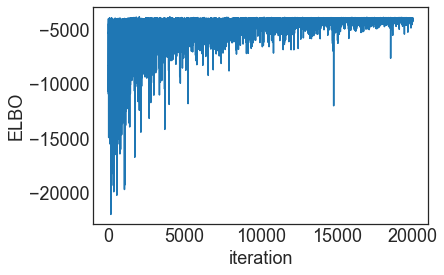

In [8]:

plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');



In [16]:

bins=25

reliability_scores = {}
y_score = {}

ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=100, progressbar=False)
    

pred = ppc['out'].mean(axis=0) > 0.5

pred_binary=pred.astype(int)


y_score['BNN_VI'] = ppc['out'].mean(axis=0)
reliability_scores['BNN_VI']=\
reliability_curve(Y_test , y_score['BNN_VI'], bins=bins , normalize=False)

	Accuracy = 75.0%
	Precision: 0.750
	Recall: 0.746
	F1: 0.748



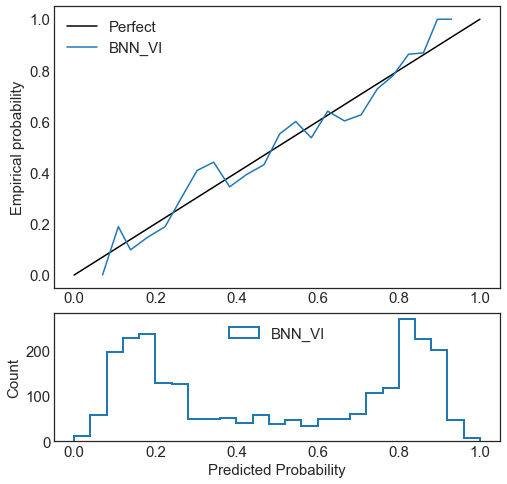

In [17]:
plt.figure(0, figsize=(8, 8))

plt.rcParams.update({'font.size': 15})
plt.subplot2grid((3, 1), (0, 0), rowspan=2)

plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect") 
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend(loc='upper center', ncol=2)
plt.savefig('reliabilityBNN_MCMC.png')


print('\tAccuracy = {}%'.format((Y_test == pred).mean() * 100))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred_binary))
print("\tRecall: %1.3f" % recall_score(Y_test, pred_binary))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred_binary))

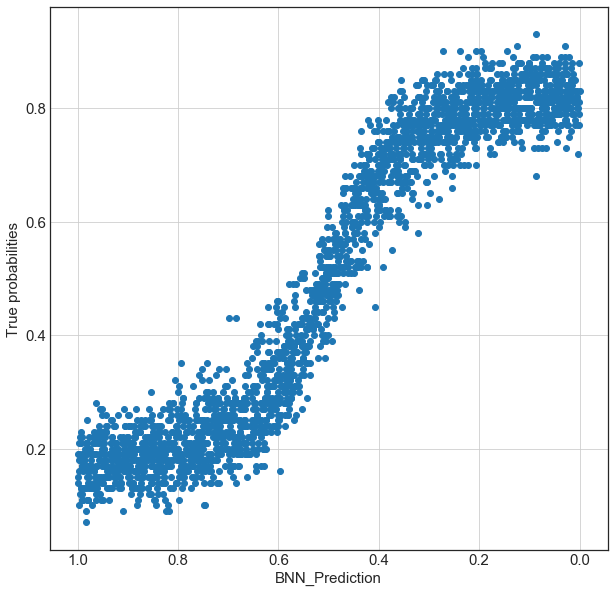

In [18]:

pred_prob=ppc['out'].mean(axis=0)
X_true=scaler.inverse_transform(X_test,copy=None)


plt.figure(figsize=(10,10))
plt.scatter(X_true[:,0],pred_prob)
plt.xlabel('BNN_Prediction')
plt.ylabel('True probabilities')
plt.grid()
plt.savefig('pred0.png')
plt.gca().invert_xaxis()
plt.show()

In [19]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=1000, progressbar=False)


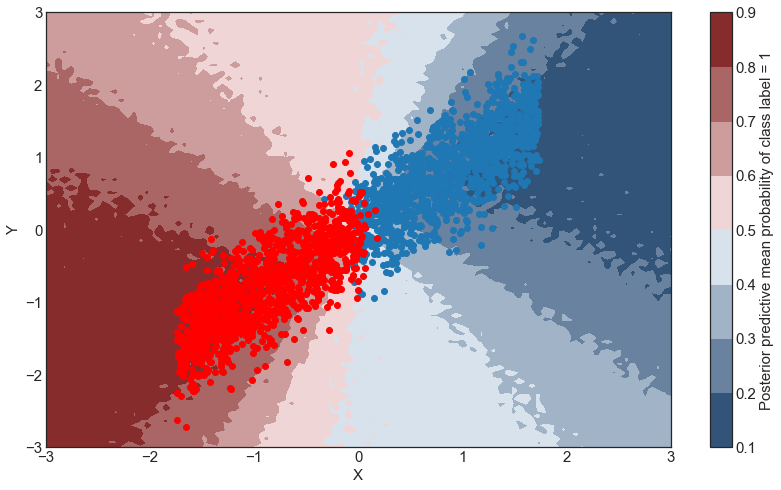

In [20]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1');
plt.savefig('predictive_prob_MCMC.png')

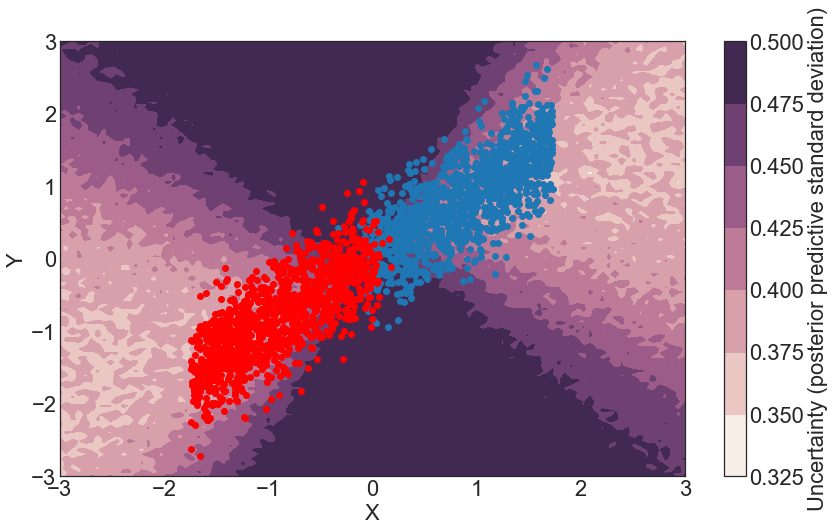

In [21]:
plt.rcParams.update({'font.size': 22})

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)')
plt.savefig('uncertainty_post_MCMC.png')



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f14936f0940>,
      dtype=object)

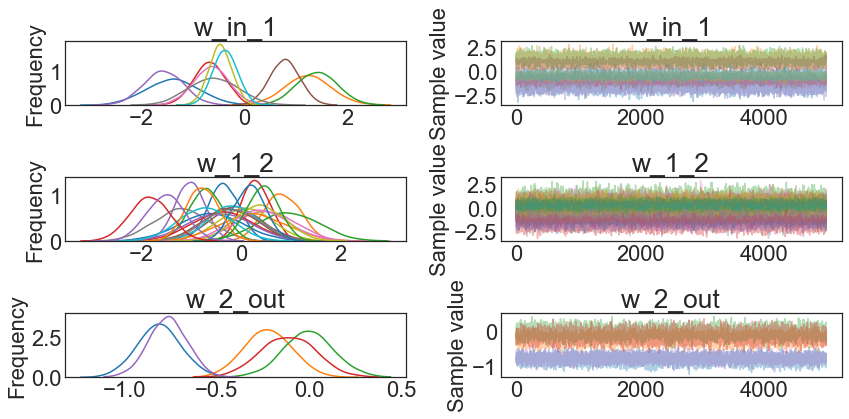

In [22]:
pm.traceplot(trace)
#plt.savefig('traceADVI.png')

## mini batch ADVI

In [23]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference= pm.ADVI()
    approx_minib = pm.fit(40000, method=inference)

Average Loss = 3,996.7: 100%|██████████| 40000/40000 [00:35<00:00, 1124.91it/s]
Finished [100%]: Average Loss = 3,996.5


In [40]:
trace_minib = approx_minib.sample(draws=100)
bins=25

reliability_scores = {}
y_score = {}

ann_input.set_value(X_test)
ann_output.set_value(Y_test)


with neural_network:
    ppc_minib = pm.sample_ppc(trace_minib, samples=100, progressbar=False)

pred = ppc_minib['out'].mean(axis=0) > 0.5
pred_binary=pred.astype(int)

y_score['BNN_VI'] = ppc_minib['out'].mean(axis=0)
reliability_scores['BNN_VI']=\
reliability_curve(Y_test , y_score['BNN_VI'], bins=bins , normalize=False)

	Accuracy = 0.7488%
	Precision: 0.750
	Recall: 0.743
	F1: 0.746



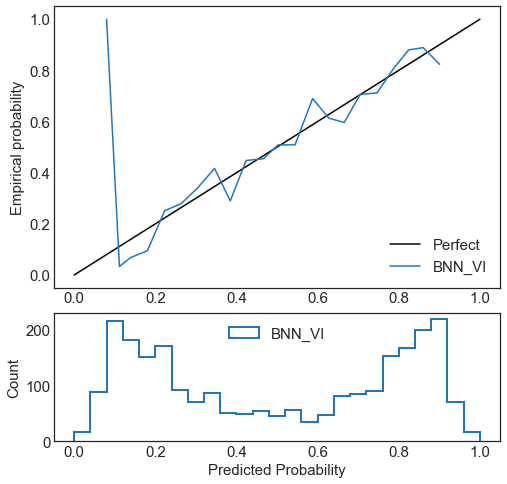

In [41]:

plt.figure(0, figsize=(8, 8))

plt.rcParams.update({'font.size': 15})
plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plt.plot([0.0, 1.0], [0.0, 1.0], 'k', label="Perfect") 
for method, (y_score_bin_mean, empirical_prob_pos) in reliability_scores.items():
    scores_not_nan = np.logical_not(np.isnan(empirical_prob_pos))
    plt.plot(y_score_bin_mean[scores_not_nan],
             empirical_prob_pos[scores_not_nan], label=method)
plt.ylabel("Empirical probability")
plt.legend(loc=0)

plt.subplot2grid((3, 1), (2, 0))
for method, y_score_ in y_score.items():
    y_score_ = (y_score_ - y_score_.min()) / (y_score_.max() - y_score_.min())
    plt.hist(y_score_, range=(0, 1), bins=bins, label=method,
             histtype="step", lw=2)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend(loc='upper center', ncol=2)
plt.savefig('reliabilityBNN_ADVI.png')


print('\tAccuracy = {}%'.format((Y_test == pred).mean() ))
print("\tPrecision: %1.3f" % precision_score(Y_test, pred_binary))
print("\tRecall: %1.3f" % recall_score(Y_test, pred_binary))
print("\tF1: %1.3f\n" % f1_score(Y_test, pred_binary))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f148d4f6320>,
      dtype=object)

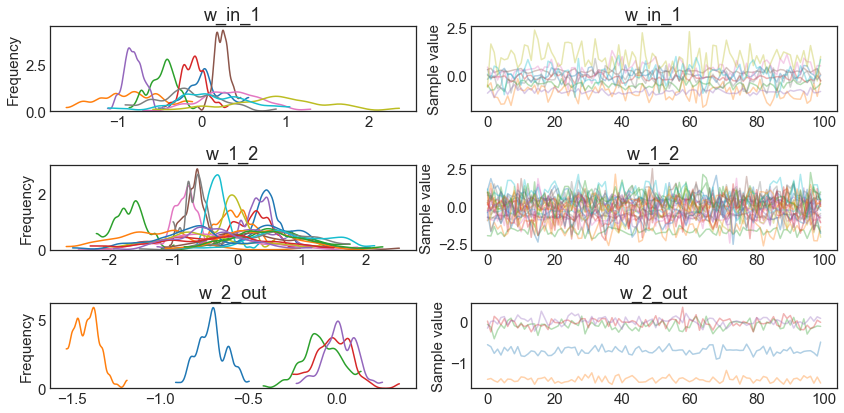

In [42]:
pm.traceplot(trace_minib)
#plt.savefig('traceADVI.png')

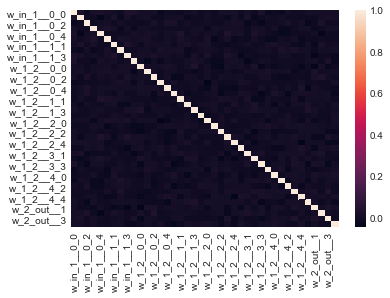

In [59]:
import pandas as pd
import seaborn as sns

df=pm.trace_to_dataframe(trace)

df=df.corr()



plt.rcParams.update({'font.size': 10})
# plot the heatmap
sns.heatmap(df)


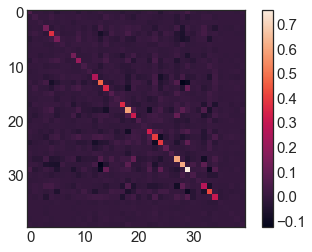

In [50]:
plt.imshow(df.cov())
plt.colorbar()
plt.show()